# Food Delivery Funnel Research

There is an order decline in a Food Delivery app starting in mid-November 2025. Overall usage (users, active users, sessions) stays stable, but buyers and orders go down.

**Question:** What caused the order drop?  
**Data:** GA4-like weekly event exports (2025 W35–W52)
**Result:** The order drop is explained by a UI change in the latest version: one of the entry point to Food Delivery is no longer available. Other entry points grow slightly, but they do not fully balance the loss

### 1) Load raw weekly exports  
Read weekly GA4-like event files (one CSV per week) into separate tables

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

p1 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W36.csv', encoding = 'utf-8')
p2 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W37.csv', encoding = 'utf-8')
p3 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W38.csv', encoding = 'utf-8')
p4 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W39.csv', encoding = 'utf-8')
p5 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W40.csv', encoding = 'utf-8')
p6 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W41.csv', encoding = 'utf-8')
p7 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W42.csv', encoding = 'utf-8')
p8 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W43.csv', encoding = 'utf-8')
p9 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W44.csv', encoding = 'utf-8')
p10 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W45.csv', encoding = 'utf-8')
p11 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W46.csv', encoding = 'utf-8')
p12 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W47.csv', encoding = 'utf-8')
p13 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W48.csv', encoding = 'utf-8')
p14 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W49.csv', encoding = 'utf-8')
p15 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W50.csv', encoding = 'utf-8')
p16 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W51.csv', encoding = 'utf-8')
p17 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2025-W52.csv', encoding = 'utf-8')
p18 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2026-W01.csv', encoding = 'utf-8')
p19 = pd.read_csv(r'C:\\Users\\Zver\\OneDrive - mariakrt.com\\Desktop\\Desktop\\2024_March\\potfolio2023\\app\\events_2026-W02.csv', encoding = 'utf-8')

### 2) Define active events for MAU/WAU  
Create a set of the event-screen pairs to reflect real product engagement. This excludes registration/login and other idle or non-product actions

In [2]:
events_active = {
         ("add_payment_info","checkout"),
         ("click","store_page"), 
         ("click","store_list"), 
         ("click","checkout"), 
         ("click","order_page"),
         ("click","menu"), 
         ("click","restaurant_list"),  
         ("click","order_history"),
         ("click","profile"), 
         ("click","profile_edit"), 
         ("click","services_hub"), 
         ("click","home"), 
         ("payment_failed","payment"),
         ("purchase","payment"),
         ("screen_view","order_status"), 
         ("screen_view","store_page"),
         ("screen_view","store_list"), 
         ("screen_view","checkout"),
         ("screen_view","order_page"), 
         ("screen_view","menu"),
         ("screen_view","home"), 
         ("screen_view","restaurant_list"), 
         ("screen_view","support"),
         ("screen_view","profile_edit"), 
         ("screen_view","services_hub"),
         ("screen_view","order_history"), 
         ("screen_view","profile")
}

### 3) Prepare clean dataset for analysis  
combine all weekly files into one table, unpack JSON fields, and create the core flags used later for MAU/WAU, funnel steps, and purchases

In [3]:
# data preparation
data_prep = [globals()['p' + str(x)] for x in range(1, 20)]
data_union = pd.concat(data_prep, axis = 0, ignore_index = True)
event_params = pd.json_normalize(data_union['EventParams'].map(json.loads))
event_params = event_params[['screen', 'service', 'button', 'order_id', 'reason']]
user_prop = pd.json_normalize(data_union['UserProperties'].map(json.loads))
user_prop = user_prop[['cohort_month', 'is_new_user', 'app_version']]
data_fin = data_union.iloc[:,:-2].join([event_params, user_prop])

data_fin['EventMonth'] = pd.to_datetime(data_fin['EventDate']).dt.to_period('M')
data_fin['EventWeek'] = pd.to_datetime(data_fin['EventDate']).dt.to_period('W-SUN')
data_fin['EventTimestamp'] = pd.to_datetime(data_fin['EventTimestamp'], unit = 'ms')

data_fin['ActiveUsers_prep'] = pd.Series(zip(data_fin['EventName'], data_fin['screen'])).isin(events_active)
data_fin['ActiveUsers'] = data_fin['PseudoID'].where(data_fin['ActiveUsers_prep'] == 1)
data_fin = data_fin.drop(columns = 'ActiveUsers_prep')

data_fin['UserswPurchases'] = data_fin['PseudoID'].where(~data_fin['order_id'].isna() & (data_fin['screen'] == 'payment'))
data_fin['SessionswPurchases'] = data_fin['SessionID'].where(~data_fin['order_id'].isna() & (data_fin['screen'] == 'payment'))

### 4) Baseline (weekly)  
Users, active users, and sessions are growing and look stable, but orders and users with purchases go down. People still use the app at the same rate, but fewer sessions end with a purchase.

In the subsequent steps, weekly view is used because the drop starts in mid-November and can be missed in monthly totals.

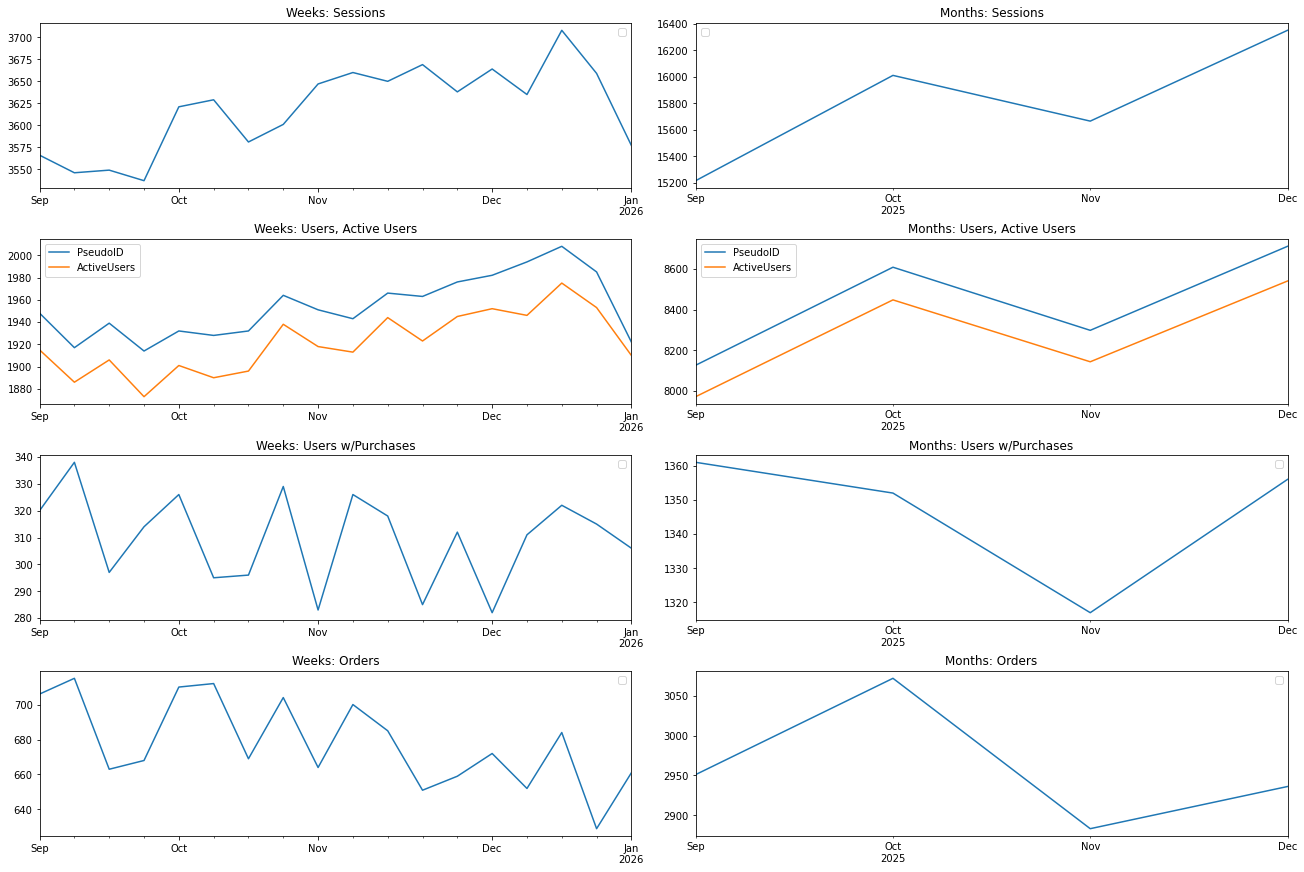

In [15]:
#groups by weeks and months
df_group_week = data_fin.groupby('EventWeek')[['SessionID', 'PseudoID', 'ActiveUsers', 'SessionswPurchases', 'UserswPurchases', 'order_id']].nunique()
df_group_month = data_fin.groupby('EventMonth')[['SessionID', 'PseudoID', 'ActiveUsers', 'SessionswPurchases', 'UserswPurchases', 'order_id']].nunique()

fig, pl = plt.subplots(nrows = 4, ncols = 2, figsize = (18,12), constrained_layout=True)

df_group_week.iloc[0:-1, 0:1].plot(kind = 'line', ax = pl[0,0])
pl[0,0].set_title('Weeks: Sessions')
pl[0,0].set_xlabel('')
pl[0,0].legend('')

df_group_month.iloc[:-1, 0:1].plot(kind = 'line', ax = pl[0,1])
pl[0,1].set_title('Months: Sessions')
pl[0,1].set_xlabel('')
pl[0,1].legend('')

df_group_week.iloc[0:-1, 1:-3].plot(kind = 'line', ax = pl[1,0])
pl[1,0].set_title('Weeks: Users, Active Users')
pl[1,0].set_xlabel('')

df_group_month.iloc[:-1, 1:-3].plot(kind = 'line', ax = pl[1,1])
pl[1,1].set_title('Months: Users, Active Users')
pl[1,1].set_xlabel('')

df_group_week.iloc[0:-1, 4:5].plot(kind = 'line', ax = pl[2,0])
pl[2,0].set_title('Weeks: Users w/Purchases')
pl[2,0].set_xlabel('')
pl[2,0].legend('')

df_group_month.iloc[:-1, 4:5].plot(kind = 'line', ax = pl[2,1])
pl[2,1].set_title('Months: Users w/Purchases')
pl[2,1].set_xlabel('')
pl[2,1].legend('')

df_group_week.iloc[0:-1, 5:6].plot(kind = 'line', ax = pl[3,0])
pl[3,0].set_title('Weeks: Orders')
pl[3,0].set_xlabel('')
pl[3,0].legend('')

df_group_month.iloc[:-1, 5:6].plot(kind = 'line', ax = pl[3,1])
pl[3,1].set_title('Months: Orders')
pl[3,1].set_xlabel('')
pl[3,1].legend('')


### 5) Compare services to isolate the drop (Food vs Grocery)  
Orders, buyers, and purchase sessions fall in Food Delivery, but not in Grocery Delivery. Payment failures and the failure rate stay stable, so the drop is not explained by it. 

In the subsequent steps, only Food service data will be analysed.

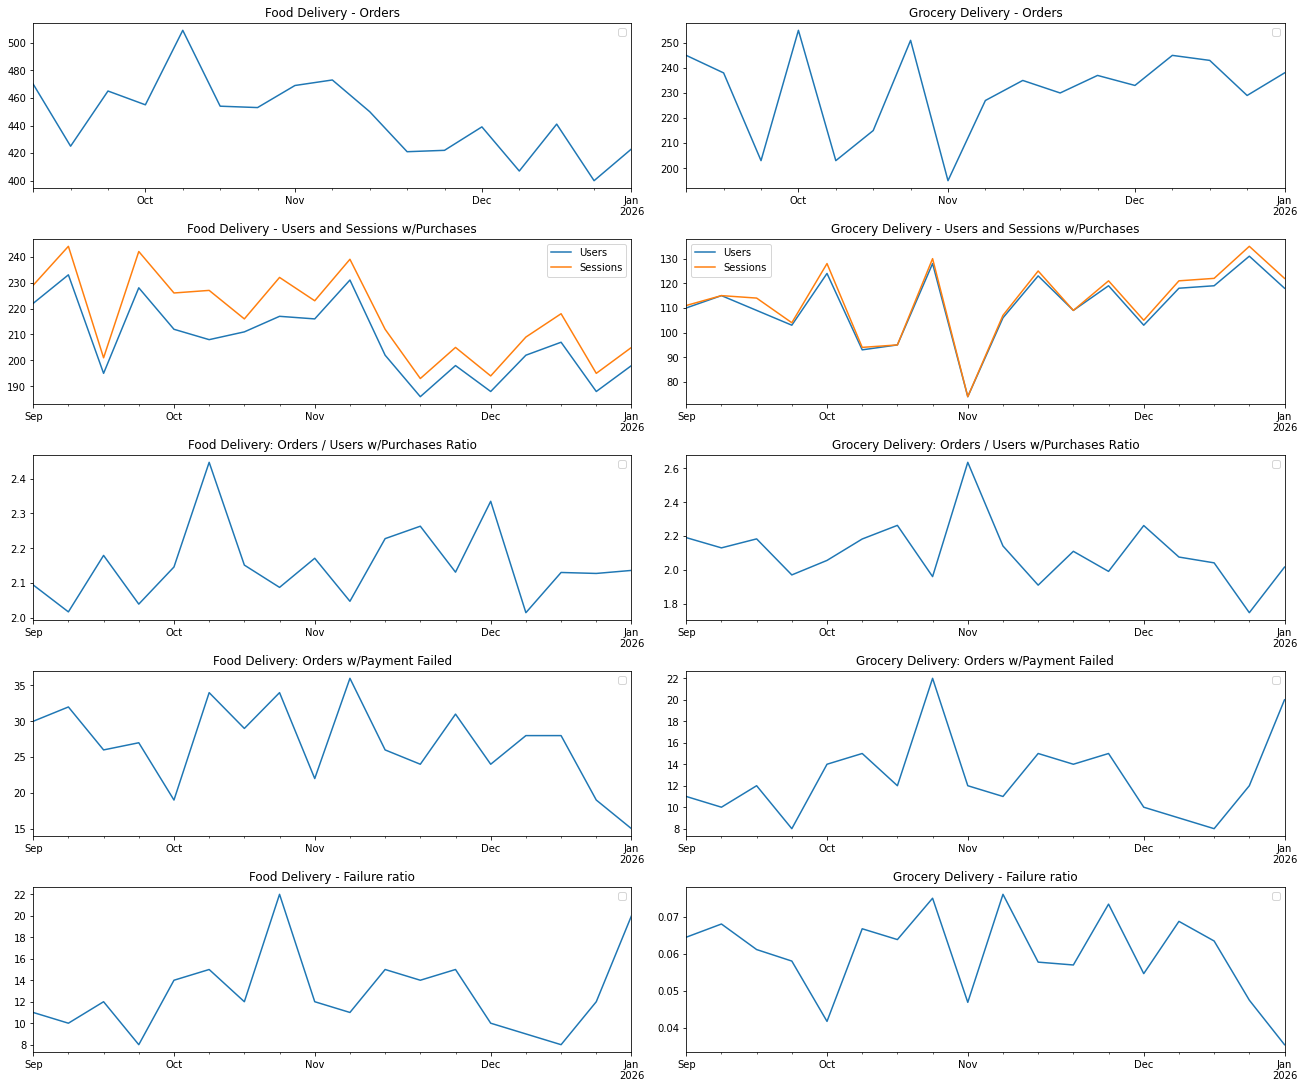

In [16]:
# by service types 
order_types = (data_fin[data_fin['service'].notna()][['EventWeek', 'order_id', 'service']]
               .pivot_table(values = 'order_id', index = 'EventWeek', columns = 'service', aggfunc = 'nunique'))

cancelled_order_fd = (data_fin[(data_fin['service'] == 'food_delivery') & (data_fin['reason'].notna())][['EventWeek', 'order_id', 'service', 'reason']]
               .pivot_table(values = 'order_id', index = 'EventWeek', aggfunc = 'nunique'))
cancelled_order_gd = (data_fin[(data_fin['service'] == 'grocery_delivery') & (data_fin['reason'].notna())][['EventWeek', 'order_id', 'service', 'reason']]
               .pivot_table(values = 'order_id', index = 'EventWeek', aggfunc = 'nunique'))

orders_all = (order_types.merge(pd.concat([cancelled_order_fd.add_suffix('_fd'), cancelled_order_gd.add_suffix('_gd')], axis = 1), 
                                left_index = True, right_index = True, how = 'left'))
              
orders_all['cancellation_ratio_fd'] = orders_all['order_id_fd'] / orders_all['food_delivery']
orders_all['cancellation_ratio_gd'] = orders_all['order_id_gd'] / orders_all['grocery_delivery']

buyers_by_types = (data_fin[data_fin['service'].notna()][['EventWeek', 'UserswPurchases', 'service']]
                   .pivot_table(values = 'UserswPurchases', index = 'EventWeek', columns = 'service', aggfunc = 'nunique'))

sessions_by_types = (data_fin[data_fin['service'].notna()][['EventWeek', 'SessionswPurchases', 'service']]
                   .pivot_table(values = 'SessionswPurchases', index = 'EventWeek', columns = 'service', aggfunc = 'nunique'))

orders_per_buyer = order_types.merge(buyers_by_types, left_index = True, right_index = True, suffixes = ('_o','_b')).reset_index()
orders_per_buyer['orders_per_buyer_fd'] = orders_per_buyer['food_delivery_o'] / orders_per_buyer['food_delivery_b']
orders_per_buyer['orders_per_buyer_gd'] = orders_per_buyer['grocery_delivery_o'] / orders_per_buyer['grocery_delivery_b']
orders_per_buyer = orders_per_buyer.iloc[:-1, [0,5,6]]
    
fig, plx = plt.subplots(nrows = 5, ncols = 2, figsize = (18, 15), constrained_layout=True)

order_types.iloc[1:-1,:1].plot(kind = 'line', ax = plx[0,0])
plx[0,0].set_title('Food Delivery - Orders')
plx[0,0].set_xlabel('')
plx[0,0].legend('')
# plx[0,0].set_ylim(bottom = 0)

order_types.iloc[1:-1,1:].plot(kind = 'line', ax = plx[0,1])
plx[0,1].set_title('Grocery Delivery - Orders')
plx[0,1].set_xlabel('')
plx[0,1].legend('')
# plx[0,1].set_ylim(bottom = 0)

buyers_by_types.iloc[:-1,:1].plot(kind = 'line', ax = plx[1,0])
plx[1,0].set_title('Food Delivery - Users and Sessions w/Purchases')
plx[1,0].set_xlabel('')
plx[1,0].legend(['Users','Sessions'])
# plx[1,0].set_ylim(bottom = 0)

buyers_by_types.iloc[:-1,1].plot(kind = 'line', ax = plx[1,1])
plx[1,1].set_title('Grocery Delivery - Users and Sessions w/Purchases')
plx[1,1].set_xlabel('')
plx[1,1].legend(['Users','Sessions'])
# plx[1,1].set_ylim(bottom = 0)

sessions_by_types.iloc[:-1,:1].plot(kind = 'line', ax = plx[1,0])
plx[1,0].set_title('Food Delivery - Users and Sessions w/Purchases')
plx[1,0].set_xlabel('')
plx[1,0].legend(['Users','Sessions'])
# plx[1,0].set_ylim(bottom = 0)

sessions_by_types.iloc[:-1,1].plot(kind = 'line', ax = plx[1,1])
plx[1,1].set_title('Grocery Delivery - Users and Sessions w/Purchases')
plx[1,1].set_xlabel('')
plx[1,1].legend(['Users','Sessions'])
# plx[1,1].set_ylim(bottom = 0)

orders_per_buyer.iloc[:,:2].plot(kind = 'line', x = 'EventWeek', ax = plx[2,0])
plx[2,0].set_title('Food Delivery: Orders / Users w/Purchases Ratio')
plx[2,0].set_xlabel('')
plx[2,0].legend('')
# plx[2,0].set_ylim(bottom = 0)

orders_per_buyer.iloc[:,[0,2]].plot(kind = 'line', x = 'EventWeek', ax = plx[2,1])
plx[2,1].set_title('Grocery Delivery: Orders / Users w/Purchases Ratio')
plx[2,1].set_xlabel('')
plx[2,1].legend('')
# plx[2,1].set_ylim(bottom = 0)

cancelled_order_fd.iloc[:-1].plot(kind = 'line', ax = plx[3,0])
plx[3,0].set_title('Food Delivery: Orders w/Payment Failed')
plx[3,0].set_xlabel('')
plx[3,0].legend('')
# plx[3,0].set_ylim(bottom = 0)

cancelled_order_gd.iloc[:-1].plot(kind = 'line', ax = plx[3,1])
plx[3,1].set_title('Grocery Delivery: Orders w/Payment Failed')
plx[3,1].set_xlabel('')
plx[3,1].legend('')
# plx[3,1].set_ylim(bottom = 0)
    
orders_all.iloc[:-1, 3].plot(kind = 'line', ax = plx[4,0]) 
plx[4,0].set_title('Food Delivery - Failure ratio')
plx[4,0].set_xlabel('')
plx[4,0].legend('')
# plx[4,0].set_ylim(bottom = 0)

orders_all.iloc[:-1, 4].plot(kind = 'line', ax = plx[4,1]) 
plx[4,1].set_title('Grocery Delivery - Failure ratio')
plx[4,1].set_xlabel('')
plx[4,1].legend('')
# plx[4,1].set_ylim(bottom = 0)

### 6) Food Delivery funnel setup
Create a funnel: steps and a step order to compute unique users/sessions and funnel conversion

In [6]:
# funnel preparation
data_fin['funnel'] = ''
data_fin['funnel_order'] = 0

# food delivery funnel
data_fin.loc[(data_fin['EventName'] == 'click') 
             & (data_fin['screen'].isin(['home', 'services_hub', 'order_history']))
             & (data_fin['button'].isin(['food_home_tile', 'food_hub_tile', 'food_order_again'])), 'funnel'] = 'Enter Funnel'
data_fin.loc[(data_fin['EventName'] == 'screen_view') 
             & (data_fin['screen'] == 'restaurant_list')
             & (data_fin['service'] == 'food_delivery'), 'funnel'] = 'Restaurant List View'
data_fin.loc[(data_fin['EventName'] == 'click') 
             & (data_fin['screen'] == 'restaurant_list')
             & (data_fin['button'] == 'select_restaurant')
             & (data_fin['service'] == 'food_delivery'), 'funnel'] = 'Choose Restaurant'
data_fin.loc[(data_fin['EventName'] == 'screen_view') 
             & (data_fin['screen'] == 'menu')
             & (data_fin['service'] == 'food_delivery'), 'funnel'] = 'Restaurant Menu View'                                                   
data_fin.loc[(data_fin['EventName'] == 'click') 
             & (data_fin['screen'] == 'menu')
             & (data_fin['button'] == 'add_item')
             & (data_fin['service'] == 'food_delivery'), 'funnel'] = 'Add Menu Item'                    
data_fin.loc[(data_fin['EventName'] == 'click') 
             & (data_fin['screen'] == 'menu')
             & (data_fin['button'] == 'go_to_cart')
             & (data_fin['service'] == 'food_delivery'), 'funnel'] = 'Go to Cart'                
data_fin.loc[(data_fin['EventName'] == 'screen_view') 
             & (data_fin['screen'] == 'order_page')
             & (data_fin['service'] == 'food_delivery'), 'funnel'] = 'View Order'                
data_fin.loc[(data_fin['EventName'] == 'click') 
             & (data_fin['screen'] == 'order_page')
             & (data_fin['button'] == 'checkout')
             & (data_fin['service'] == 'food_delivery'), 'funnel'] = 'Go to Checkout'                
data_fin.loc[(data_fin['EventName'] == 'screen_view') 
             & (data_fin['screen'] == 'checkout')
             & (data_fin['service'] == 'food_delivery'), 'funnel'] = 'Checkout Screen View'                
data_fin.loc[(data_fin['EventName'] == 'add_payment_info') 
             & (data_fin['screen'] == 'checkout')
             & (data_fin['service'] == 'food_delivery'), 'funnel'] = 'Add payment Info(opt.)'        
data_fin.loc[(data_fin['EventName'] == 'click') 
             & (data_fin['screen'] == 'checkout')
             & (data_fin['button'] == 'pay')
             & (data_fin['service'] == 'food_delivery'), 'funnel'] = 'Click to pay'
data_fin.loc[(data_fin['EventName'] == 'payment_failed')
             & (data_fin['screen'] == 'payment')
             & (data_fin['service'] == 'food_delivery'), 'funnel'] = 'Order created fail Page'
data_fin.loc[(data_fin['EventName'] == 'purchase')
             & (data_fin['screen'] == 'payment')
             & (data_fin['service'] == 'food_delivery'), 'funnel'] = 'Order created success Page'

# food delivery funnel order
data_fin.loc[(data_fin['EventName'] == 'click') 
             & (data_fin['screen'].isin(['home', 'services_hub', 'order_history']))
             & (data_fin['button'].isin(['food_home_tile', 'food_hub_tile', 'food_order_again'])), 'funnel_order'] = 1
data_fin.loc[(data_fin['EventName'] == 'screen_view') 
             & (data_fin['screen'] == 'restaurant_list')
             & (data_fin['service'] == 'food_delivery'), 'funnel_order'] = 2
data_fin.loc[(data_fin['EventName'] == 'click') 
             & (data_fin['screen'] == 'restaurant_list')
             & (data_fin['button'] == 'select_restaurant')
             & (data_fin['service'] == 'food_delivery'), 'funnel_order'] = 3
data_fin.loc[(data_fin['EventName'] == 'screen_view') 
             & (data_fin['screen'] == 'menu')
             & (data_fin['service'] == 'food_delivery'), 'funnel_order'] = 4                                                  
data_fin.loc[(data_fin['EventName'] == 'click') 
             & (data_fin['screen'] == 'menu')
             & (data_fin['button'] == 'add_item')
             & (data_fin['service'] == 'food_delivery'), 'funnel_order'] = 5                    
data_fin.loc[(data_fin['EventName'] == 'click') 
             & (data_fin['screen'] == 'menu')
             & (data_fin['button'] == 'go_to_cart')
             & (data_fin['service'] == 'food_delivery'), 'funnel_order'] = 6                
data_fin.loc[(data_fin['EventName'] == 'screen_view') 
             & (data_fin['screen'] == 'order_page')
             & (data_fin['service'] == 'food_delivery'), 'funnel_order'] = 7                
data_fin.loc[(data_fin['EventName'] == 'click') 
             & (data_fin['screen'] == 'order_page')
             & (data_fin['button'] == 'checkout')
             & (data_fin['service'] == 'food_delivery'), 'funnel_order'] = 8                
data_fin.loc[(data_fin['EventName'] == 'screen_view') 
             & (data_fin['screen'] == 'checkout')
             & (data_fin['service'] == 'food_delivery'), 'funnel_order'] = 9               
data_fin.loc[(data_fin['EventName'] == 'add_payment_info') 
             & (data_fin['screen'] == 'checkout')
             & (data_fin['service'] == 'food_delivery'), 'funnel_order'] = 10        
data_fin.loc[(data_fin['EventName'] == 'click') 
             & (data_fin['screen'] == 'checkout')
             & (data_fin['button'] == 'pay')
             & (data_fin['service'] == 'food_delivery'), 'funnel_order'] = 11
data_fin.loc[(data_fin['EventName'] == 'payment_failed')
             & (data_fin['screen'] == 'payment')
             & (data_fin['service'] == 'food_delivery'), 'funnel_order'] = 12
data_fin.loc[(data_fin['EventName'] == 'purchase')
             & (data_fin['screen'] == 'payment')
             & (data_fin['service'] == 'food_delivery'), 'funnel_order'] = 13

# aggregated funnel
funnel_prep_gr = (data_fin[data_fin['funnel'] != '']
               .groupby(['funnel', 'funnel_order'])[['SessionID', 'PseudoID']].nunique()
               .reset_index().set_index('funnel_order'))
ep_users = max(funnel_prep_gr[funnel_prep_gr['funnel'] == 'Enter Funnel']['PseudoID'])
ep_sessions = max(funnel_prep_gr[funnel_prep_gr['funnel'] == 'Enter Funnel']['SessionID'])

funnel_fin = funnel_prep_gr.sort_index()
funnel_fin['Sessions_CR_1st'] = funnel_fin['SessionID'] / ep_sessions
funnel_fin['Users_CR_1st'] = funnel_fin['PseudoID'] / ep_users
funnel_fin['Sessions_CR_prev'] = funnel_fin['SessionID'] / funnel_fin['SessionID'].shift(1)
funnel_fin['Users_CR_prev'] = funnel_fin['PseudoID'] / funnel_fin['PseudoID'].shift(1)

# detailed funnel
funnel_prep_det = (data_fin[data_fin['funnel'] != '']
                   .groupby(['EventWeek', 'funnel', 'funnel_order'])[['SessionID', 'PseudoID']].nunique()
                   .reset_index().set_index('EventWeek')
                   .pivot_table(values = 'PseudoID', index = 'EventWeek', columns = ['funnel_order', 'funnel']))

### 7) Overall Food funnel view  
Plot the funnel for sessions and users to get a high-level picture. 'Add payment info' is an optional step. The last steps split into successful purchases and failed payments

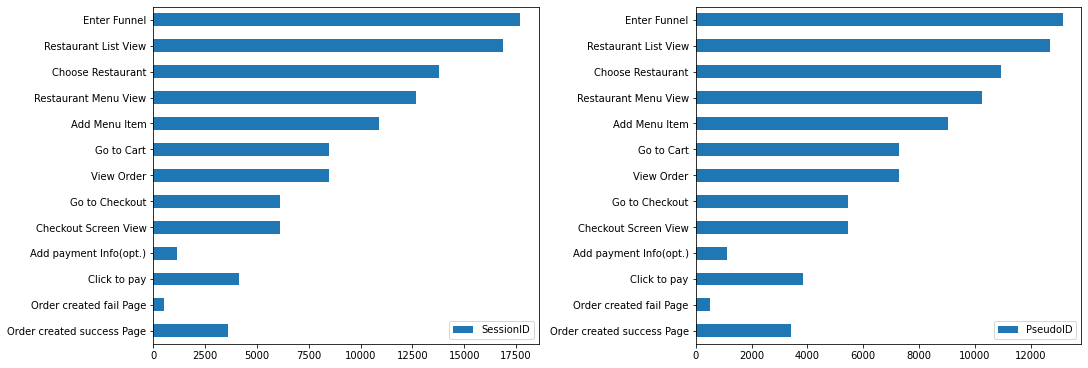

,funnel,SessionID,PseudoID,Sessions_CR_1st,Users_CR_1st,Sessions_CR_prev,Users_CR_prev
funnel_order,,,,,,,
1,Enter Funnel,17709,13156,1.000000,1.000000,NaN,NaN
2,Restaurant List View,16847,12700,0.951324,0.965339,0.951324,0.965339
3,Choose Restaurant,13800,10933,0.779265,0.831028,0.819137,0.860866
4,Restaurant Menu View,12690,10241,0.716585,0.778428,0.919565,0.936705
5,Add Menu Item,10881,9038,0.614433,0.686987,0.857447,0.882531
6,Go to Cart,8480,7299,0.478853,0.554804,0.779340,0.807590
7,View Order,8480,7299,0.478853,0.554804,1.000000,1.000000
8,Go to Checkout,6098,5470,0.344345,0.415780,0.719104,0.749418
9,Checkout Screen View,6098,5470,0.344345,0.415780,1.000000,1.000000


In [7]:
fig, f = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5), constrained_layout = True)
funnel_fin.sort_index(ascending = False).plot(kind = 'barh', x = 'funnel', y = 'SessionID', ax = f[0])
f[0].set_ylabel('')
funnel_fin.sort_index(ascending = False).plot(kind = 'barh', x = 'funnel', y = 'PseudoID', ax = f[1])
f[1].set_ylabel('')
plt.show()
funnel_fin

### 8) Food Delivery funnel weekly trends
Create a weekly funnel chart to see when the drop starts and which steps change first. The drop is in all steps, no steps stand out, so someting happens before the funnel.

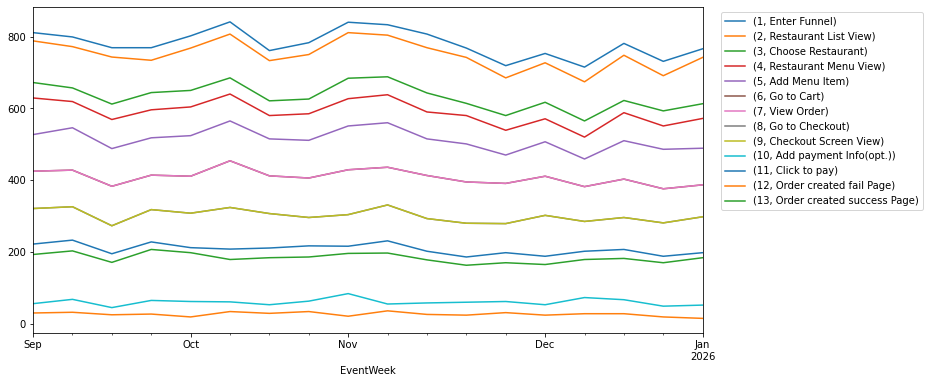

In [8]:
funnel_prep_det.iloc[:-1].plot(kind = 'line', figsize = (12,6)).legend(bbox_to_anchor=(1.02, 1))

### 9) App version view (sessions and funnel entry rate)  
Split sessions by app versions and compare the share of sessions that enter the Food Delivery funnel. This helps to see if the behavior change is linked to a specific app release.
In the latest app version 5.9.0, the share of sessions that that enter the Food Delivery funnel is lower than in older versions

<Axes: xlabel='AppVersion', ylabel='EventWeek'>

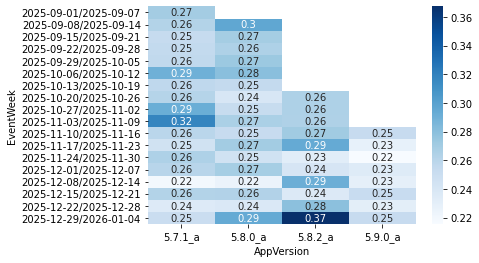

In [12]:
app_ver_all = data_fin.groupby(['EventWeek', 'AppVersion'])['SessionID'].nunique().reset_index()
app_ver_fd = data_fin[data_fin['funnel_order'] == 1].groupby(['EventWeek', 'AppVersion'])['SessionID'].nunique().reset_index()
app_ver_ausers = app_ver_all.pivot_table(values = 'SessionID', index = 'EventWeek', columns = 'AppVersion')
app_ver_fdusers = app_ver_fd.pivot_table(values = 'SessionID', index = 'EventWeek', columns = 'AppVersion')
app = pd.merge(app_ver_ausers, app_ver_fdusers, left_index = True, right_index = True, suffixes = ('_a', '_fd'))

l = int(len(app.columns)/2)
num = app.iloc[:-1, l:].to_numpy()
den = app.iloc[:-1, :l].to_numpy()
t = pd.DataFrame(num / den, index=app.iloc[:-1].index, columns = app.iloc[:,:l].columns)
sns.heatmap(t, annot=True, cmap = 'Blues')

### 10) Looking into the differences of the app versions  
For each app version, count weekly users and sessions that enter the Food Delivery funnel from each entry point (Home, Hub, Order History). As expected, the older version are disappearing, but **also in the version 5.9.0 the Hub entry point is missing**

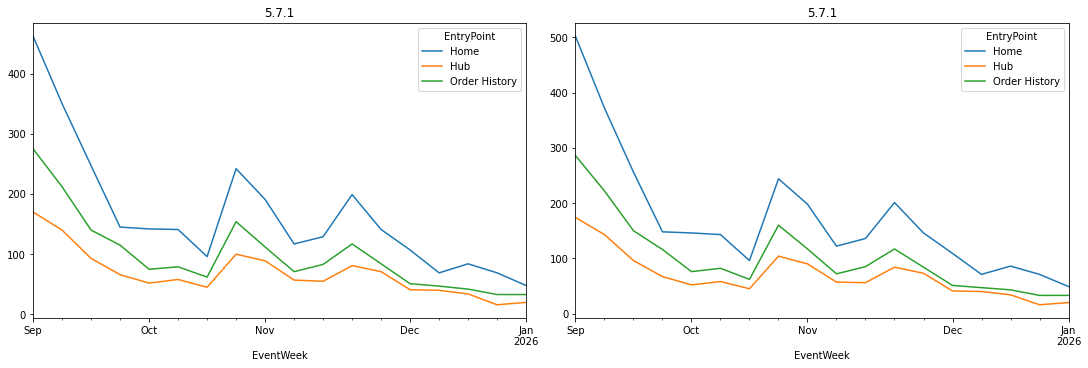

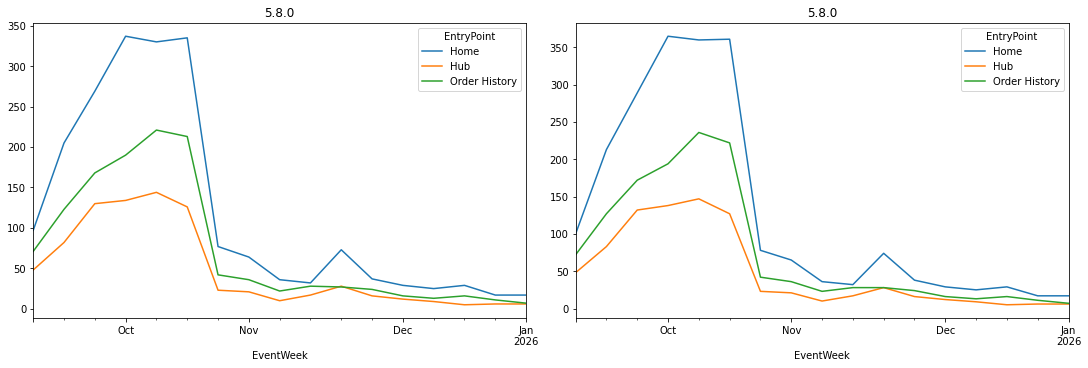

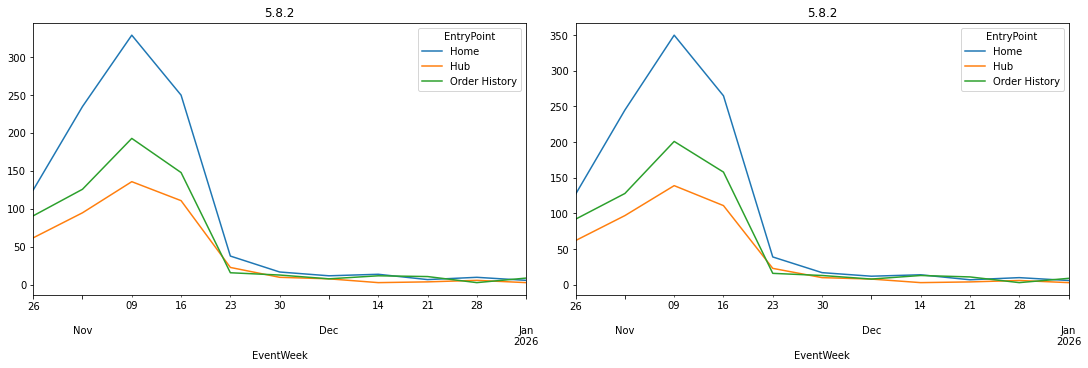

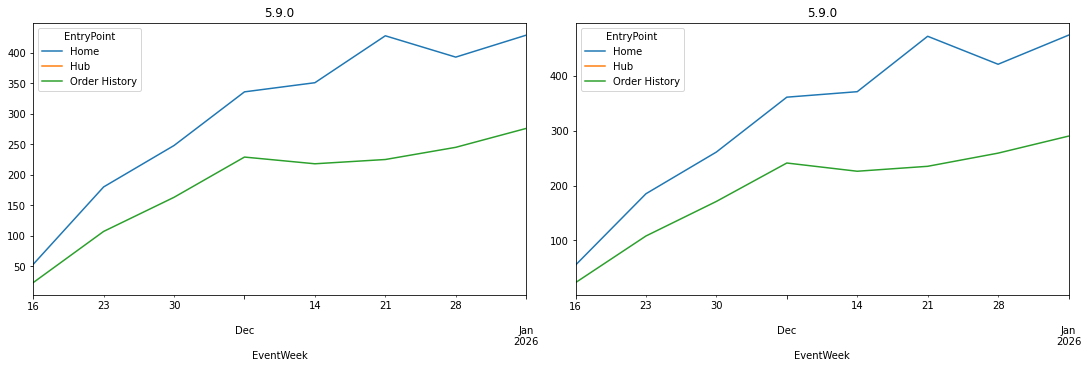

In [10]:
# entry points: clicks
# button: 'food_home_tile', 'food_hub_tile', 'food_order_again'
data_fin['EntryPoint'] = ''
data_fin.loc[(data_fin['EventName'] == 'click') 
             & (data_fin['button'] == 'food_home_tile') 
             & (data_fin['funnel'] == 'Enter Funnel'), 'EntryPoint'] = 'Home' 
data_fin.loc[(data_fin['EventName'] == 'click') 
             & (data_fin['button'] == 'food_hub_tile')
             & (data_fin['funnel'] == 'Enter Funnel'), 'EntryPoint'] = 'Hub' 
data_fin.loc[(data_fin['EventName'] == 'click') 
             & (data_fin['button'] == 'food_order_again')
             & (data_fin['funnel'] == 'Enter Funnel'), 'EntryPoint'] = 'Order History' 


ep_groups = data_fin[data_fin['EntryPoint'] != ''].groupby(['EventWeek', 'AppVersion','EntryPoint'])[['PseudoID', 'SessionID']].nunique()
ep_groups = ep_groups.pivot_table(values = ['PseudoID','SessionID'], index = ['EventWeek', 'AppVersion'], columns = 'EntryPoint').reset_index()

versions = pd.DataFrame(ep_groups.reset_index()['AppVersion'].unique())
n = 0
l = int(len(versions))

while n <= 3:
    for i in versions:
        i = n
        fig, e = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5), constrained_layout = True)
        ep_groups[ep_groups['AppVersion'] == versions.iloc[i].item()].iloc[:-1].plot(kind = 'line', y = 'PseudoID', x = 'EventWeek', ax = e[0])
        e[0].set_title(f'{versions.iloc[i].item()}')
        ep_groups[ep_groups['AppVersion'] == versions.iloc[i].item()].iloc[:-1].plot(kind = 'line', y = 'SessionID', x = 'EventWeek',ax = e[1])
        e[1].set_title(f'{versions.iloc[i].item()}')
        plt.show()
        n += 1


### 11) Orders by entry point
Link each order to the closest earlier Food Delivery funnel entry point in the same user session. Then count weekly orders by entry point, both by app version and overall. 
This shows that **the Hub entry point disappears in the latest version**, and **this missing entry point explains the total drop in orders**

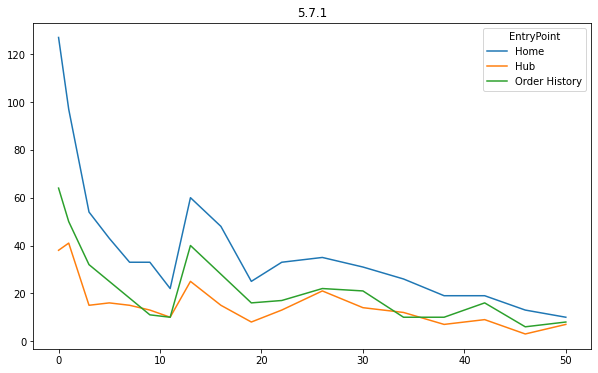

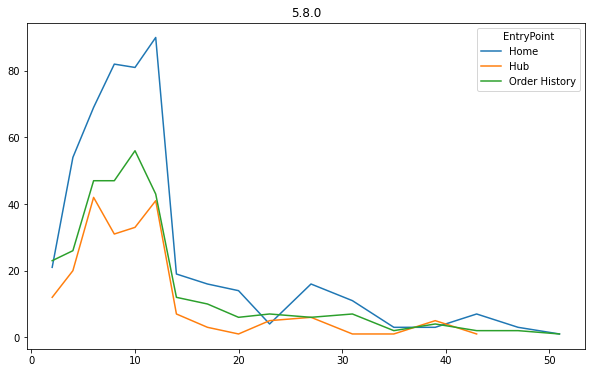

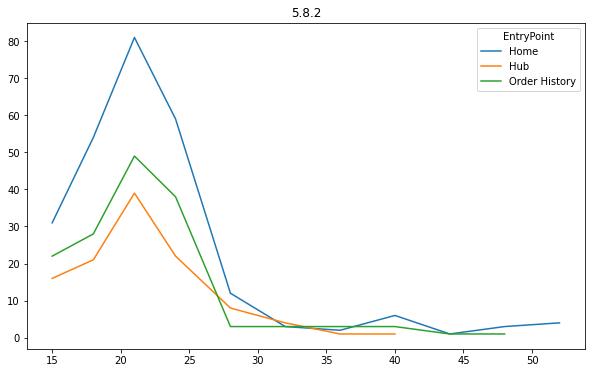

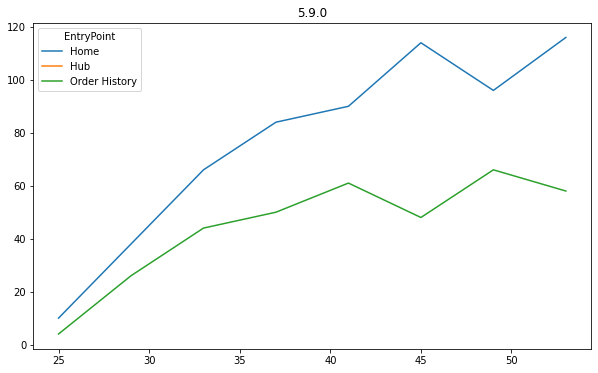

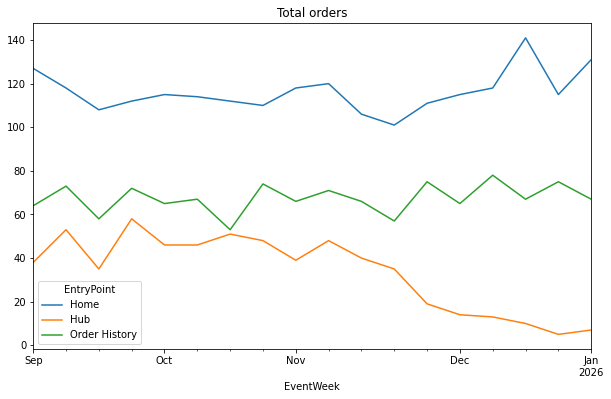

In [17]:
# entry points to orders
ep_prep = (data_fin[(data_fin['EntryPoint'] != '') | (data_fin['order_id'].notna() & data_fin['funnel_order'].isin([12,13]))]
                  [['EventDate','EventTimestamp','PseudoID','SessionID','order_id','EventName','button', 'EntryPoint', 'AppVersion']])
    
ep_orders = (ep_prep[ep_prep['order_id']
             .notna()]
             .drop_duplicates()
             .reset_index())[['EventDate','PseudoID', 'SessionID', 'EventTimestamp', 'order_id', 'AppVersion']]

ep = (ep_prep[ep_prep['EntryPoint'] != '']
      .drop_duplicates()
      .reset_index())[['EventDate','PseudoID', 'SessionID', 'EventTimestamp', 'EntryPoint', 'AppVersion']]

ep_merge = ep.merge(ep_orders, on = ['PseudoID', 'SessionID', 'EventDate'], suffixes  = ('_e', '_o'))
ep_merge = ep_merge[ep_merge['EventTimestamp_o'] > ep_merge['EventTimestamp_e']]
ep_merge = ep_merge.sort_values(by =  ['PseudoID', 'SessionID', 'EventDate', 'EventTimestamp_e'], ascending = False)
ep_merge['rnk'] = ep_merge.groupby(['PseudoID', 'SessionID', 'EventDate']).cumcount()+1
ep_merge = ep_merge[ep_merge['rnk'] == 1][['EventDate', 'order_id', 'EntryPoint', 'AppVersion_o']]
ep_merge['EventWeek'] = pd.to_datetime(ep_merge['EventDate']).dt.to_period('W-SUN')
ep_merge_gr = pd.DataFrame(ep_merge.groupby(['EventWeek', 'EntryPoint', 'AppVersion_o'])['order_id'].nunique())
ep_merge_gr = ep_merge_gr.pivot_table(values = 'order_id', index = ['EventWeek', 'AppVersion_o'], columns = 'EntryPoint').reset_index()

versions = pd.DataFrame(ep_merge_gr.reset_index()['AppVersion_o'].unique())
n = 0
l = int(len(versions))

while n <= 3:
    for i in versions:
        i = n
        ep_merge_gr[ep_merge_gr['AppVersion_o'] == versions.iloc[i].item()].iloc[:-1].plot(kind = 'line', figsize = (10,6)).set_title(f'{versions.iloc[i].item()}')
        plt.show()
        n += 1
ep_merge_gr_t = (pd.DataFrame(ep_merge.groupby(['EventWeek', 'EntryPoint'])['order_id'].nunique())
                 .pivot_table(values = 'order_id', index = 'EventWeek', columns = 'EntryPoint'))
ep_merge_gr_t.iloc[:-1, ].plot(kind = 'line', figsize = (10,6)).set_title('Total orders')
plt.show()